## Чтение данных

Будем итерироваться по всем доступным экселкам и считывать всю значащую информацию по компании в отдельный датафрейм. Потом сделаем словарик со всеми отчетностями, где ключ - название компании, значение - датафрейм с ее отчетностью.

In [68]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import isnan
import os

In [77]:
def unpack_financial_statement(df):
    timeline = list(df.iloc[26])[9:]
    timeline.insert(0, 'Category')
    data = []
    for i in range(28, len(df)):
        row = list(df.iloc[i])
        if not type(row[8]) is float:
            data.append(row[8:])
    return pd.DataFrame(data=data, columns=timeline)      

In [92]:
fin_statements = {}
for company in os.listdir('oil_gas_train'):
    df = pd.read_excel(f'oil_gas_train/{company}')
    x = unpack_financial_statement(df)
    fin_statements[company[:-5]] = x

## EDA

EDA будем проводить на примере одной из компании - AMPY. 

In [96]:
df = fin_statements['AMPY']
df.head()

,Category,Q1 '11 A,Q2 '11 A,Q3 '11 A,Q4 '11 A,Q1 '12 A,Q2 '12 A,Q3 '12 A,Q4 '12 A,Q1 '13 A,...,Q1 '18 A,Q2 '18 A,Q3 '18 A,Q4 '18 A,Q1 '19 A,Q2 '19 A,Q3 '19 A,Q4 '19 A,Q1 '20 A,Q2 '20 A
0,Revenue,0,0,0,61.863,48.41,49.259,55.498,89.839,86.142,...,52.844,53.672,85.522,75.702,65.155,59.532,72.959,77.929,58.136,35.171
1,Consensus:,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,79.8,63.3,46.7
2,% Surprise | % Est. vs Consensus,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,-0.0234461,-0.0815798,-0.246874
3,Revenue Growth (YoY),NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.452225,0.779426,...,-0.121463,0.00913774,0.521338,0.419129,0.232969,0.109182,-0.146898,0.029418,-0.107728,-0.409208
4,Cost of Revenue,0,0,0,-36.854,-34.628,-33.967,-37.426,-50.763,-56.101,...,-30.318,-33.686,-40.86,-43.524,-41.387,-40.537,-48.594,-53.374,-52.792,-36.99


Заметим, что за первые 3 квартала 11-го года данных нет, поэтому удалим соответствующие столбцы:

In [103]:
df = df.drop(columns=['Q1 \'11 A', 'Q2 \'11 A', 'Q3 \'11 A'])

In [111]:
df.shape # у нас есть данные за 36 кварталов, всего 336 показателей

(336, 36)

Посчитаем описательные статистики для основных показателей:

In [119]:
categories = ['Revenue', 'Gross Profit', 'Total Assets']
for category in categories:
    series = np.array(df[df.Category == category].iloc[0])[1:]
    print(f'Показатель: {category}')
    print(f'Минимум: {min(series)}')
    print(f'Максимум: {max(series)}')
    print(f'Среднее: {np.mean(series)}')
    print(f'Стандартное отклонение: {np.std(series)}')
    print(f'Размах: {max(series) - min(series)}')
    print('========================================')

Показатель: Revenue
Минимум: 35.171
Максимум: 166.518
Среднее: 86.59597120000002
Стандартное отклонение: 39.77068508998741
Размах: 131.347
Показатель: Gross Profit
Минимум: -1.8190000000000015
Максимум: 76.038
Среднее: 34.197885485714295
Стандартное отклонение: 19.444568719696672
Размах: 77.857
Показатель: Total Assets
Минимум: 453.683008
Максимум: 2704.470016
Среднее: 1200.9308800000001
Стандартное отклонение: 728.7789166786999
Размах: 2250.7870080000002


In [123]:
import matplotlib.ticker as ticker

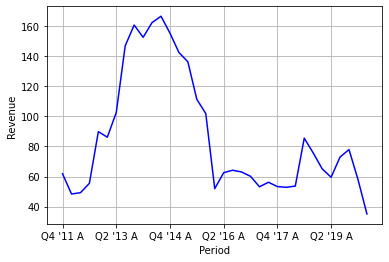

In [128]:
fig, ax = plt.subplots()
ax.plot(list(df.columns)[1:], list(df[df.Category == 'Revenue'].iloc[0])[1:], color='blue')

ax.grid()
ax.xaxis.set_major_locator(ticker.MultipleLocator(6))
plt.xlabel('Period')
plt.ylabel('Revenue')

plt.show()

В 12-14 годах был пик выручки, после чего она вернулась к значениям 11 года

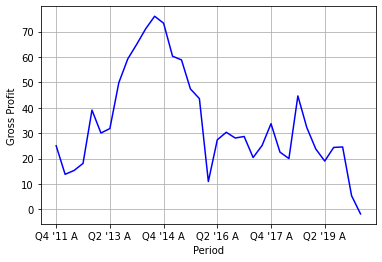

In [129]:
fig, ax = plt.subplots()
ax.plot(list(df.columns)[1:], list(df[df.Category == 'Gross Profit'].iloc[0])[1:], color='blue')

ax.grid()
ax.xaxis.set_major_locator(ticker.MultipleLocator(6))
plt.xlabel('Period')
plt.ylabel('Gross Profit')

plt.show()

Приыбль, ожидаемо, похожа на выручку, в 20 году компания апервые стала убыточной.

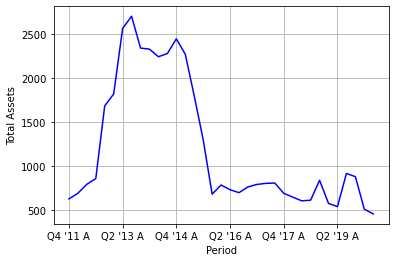

In [130]:
fig, ax = plt.subplots()
ax.plot(list(df.columns)[1:], list(df[df.Category == 'Total Assets'].iloc[0])[1:], color='blue')

ax.grid()
ax.xaxis.set_major_locator(ticker.MultipleLocator(6))
plt.xlabel('Period')
plt.ylabel('Total Assets')

plt.show()

в 13-14 году активы компании были в 5 раз больше, чем во все остальное время до и после

## Метрика

В качестве метрики для прогнозирования выручки и прибыли по отдельности можно брать mse, которое мы считаем как усредненное mse по всем периодам прогноза данного показателя. В качестве характеристики того, насколько хорошо мы предсказали выручку и прибыль в совокупности, можно взять среднее гармоническое из mse_revenue и mse_profit.